In [930]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
import matplotlib as mpl
import matplotlib.font_manager as fm
from matplotlib.colors import LinearSegmentedColormap
from wordcloud import WordCloud
import re
from collections import Counter


In [931]:
font_path = "./FormaDJRCyrillicDeck-Regular-Testing.otf"
fm.fontManager.addfont(font_path)
prop = fm.FontProperties(fname=font_path)
mpl.rcParams["font.family"] = prop.get_name()
mpl.rcParams["font.sans-serif"] = [prop.get_name()]

mpl.rcParams.update({
    "text.color": "#481B00",
    "axes.labelcolor": "#481B00",
    "axes.titlecolor": "#481B00",
    "xtick.color": "#481B00",
    "ytick.color": "#481B00",
    "axes.edgecolor": "#481B00",
    
    "figure.facecolor": "#FFF6E6",
    "axes.facecolor": "#FFF6E6",
    "savefig.facecolor": "#FFF6E6",
})

### убираем ненужные колонки

In [932]:
df = pd.read_csv('bts_v13.csv', encoding='utf-16')

df = df.drop(columns=['id', 'spotify_track_id', 'spotify_album_id', 'eng_lyrics_source_url', 'eng_lyrics_credits', 'raw_track_title', 'featured'], errors='ignore') 
#слишком много было пустых ячеек, от 80% датасета, не будут полезными; также удалила айди, они не информативны
df.head(10)

,album_title,eng_album_title,album_rd,album_seq,track_title,eng_track_title,lyrics,hidden_track,remix,performed_by,...,spotify_track_key,spotify_track_loudness,spotify_track_mode,spotify_track_speechiness,spotify_track_acousticness,spotify_track_instrumentalness,spotify_track_liveness,spotify_track_valence,spotify_track_tempo,spotify_track_time_signature
0,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,1,Intro: 2 Cool 4 Skool (ft. DJ Friz),Intro: 2 Cool 4 Skool (ft. DJ Friz),we're now going to progress to some steps\nwhi...,False,False,RM,...,8.0,-6.249,1.0,0.2450,0.1790,0.266000,0.1790,0.532,94.871,4.0
1,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,2,We Are Bulletproof Pt.2,We Are Bulletproof Pt.2,(what) give it to me\n (what) be nervous\n (wh...,False,False,BTS,...,8.0,-5.090,0.0,0.1600,0.0104,0.000006,0.1340,0.868,144.020,4.0
2,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,3,Skit: Circle Room Talk,Skit: Circle Room Talk,rap monster: it was a big hit\nv: year 2006!\n...,False,False,BTS,...,9.0,-18.009,1.0,0.8020,0.9120,0.000000,0.9130,0.817,121.045,3.0
3,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,4,No More Dream,No More Dream,"hey, what's your dream?\n hey, what's your dre...",False,False,BTS,...,2.0,-5.185,1.0,0.4700,0.0118,0.000002,0.4310,0.594,167.898,4.0
4,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,5,Interlude,Interlude,NaN,False,False,BTS,...,1.0,-13.392,0.0,0.3190,0.4940,0.762000,0.3920,0.854,125.897,4.0
5,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,6,좋아요 (I Like It),I Like It,wanna be loved‚Ä¶\n\ndon't wanna be fool wanna...,False,False,BTS,...,0.0,-4.165,0.0,0.0705,0.3030,0.000000,0.2600,0.783,100.939,4.0
6,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,7,Outro: Circle Room Cypher,Outro: Circle Room Cypher,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",False,False,BTS,...,7.0,-11.608,1.0,0.5230,0.5360,0.000000,0.1890,0.852,94.077,4.0
7,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,8,Skit: On The Start Line,Skit: On The Start Line,"ah-ah\ntrainee\nin many ways, this term define...",True,False,BTS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,9,길 (Road/Path),Road/Path,"yeah, wassup\nyou know, time flows like stars\...",True,False,BTS,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,"O!RUL8,2?","O!RUL8,2?",2013-09-11,1,"Intro: O!RUL8,2?","Intro: O!RUL8,2?",nothing lasts forever\nyou only live once\nso ...,False,False,RM,...,7.0,-5.029,1.0,0.3930,0.2720,0.000000,0.0945,0.188,150.140,4.0


### Смотрим на пропуски

Заполним медианой численные значения, т.к. пропусков немного (23), а данных у нас достаточно

In [933]:
df.isnull().sum()


album_title                        0
eng_album_title                    0
album_rd                           0
album_seq                          0
track_title                        0
eng_track_title                    0
lyrics                            31
hidden_track                       0
remix                              0
performed_by                      23
repackaged                         0
lang                              22
has_full_ver                       0
is_alt_lang_ver                    0
spotify_track_duration_ms         23
spotify_track_danceability        23
spotify_track_energy              23
spotify_track_key                 23
spotify_track_loudness            23
spotify_track_mode                23
spotify_track_speechiness         23
spotify_track_acousticness        23
spotify_track_instrumentalness    23
spotify_track_liveness            23
spotify_track_valence             23
spotify_track_tempo               23
spotify_track_time_signature      23
d

In [934]:
spotify_cols = [
    'spotify_track_duration_ms',
    'spotify_track_danceability',
    'spotify_track_energy',
    'spotify_track_key',
    'spotify_track_loudness',
    'spotify_track_mode',
    'spotify_track_speechiness',
    'spotify_track_acousticness',
    'spotify_track_instrumentalness',
    'spotify_track_liveness',
    'spotify_track_valence',
    'spotify_track_tempo',
    'spotify_track_time_signature'
]

for col in spotify_cols:
    df[col] = df[col].fillna(df[col].median())

Посмотрим на пустые колонки с текстом песен

In [935]:
empty_lyrics_df = df[df['lyrics'].isnull() | (df['lyrics'].str.strip() == '')]
print(empty_lyrics_df)


                                     album_title  \
4                                 2 Cool 4 Skool   
21                              Skool Luv Affair   
33           Skool Luv Affair (Special Addition)   
41           Skool Luv Affair (Special Addition)   
42           Skool Luv Affair (Special Addition)   
43           Skool Luv Affair (Special Addition)   
44           Skool Luv Affair (Special Addition)   
45           Skool Luv Affair (Special Addition)   
46           Skool Luv Affair (Special Addition)   
63                                       Wake Up   
66                                       Wake Up   
73                                       Wake Up   
77   화양연화 The Most Beautiful Moment In Life Pt.1   
232               BTS WORLD: Original Soundtrack   
233               BTS WORLD: Original Soundtrack   
234               BTS WORLD: Original Soundtrack   
235               BTS WORLD: Original Soundtrack   
236               BTS WORLD: Original Soundtrack   
237         

### скорее всего, песни без текста — инструменталки, поэтому создадим новую колонку и назовем ее инструментал

In [936]:
df['instrumental'] = df['lyrics'].isnull() | (df['lyrics'].str.strip() == '')
df['lyrics'] = df['lyrics'].fillna(' ')

In [937]:
df['instrumental']

0      False
1      False
2      False
3      False
4       True
       ...  
356     True
357    False
358    False
359    False
360    False
Name: instrumental, Length: 361, dtype: bool

In [938]:
missing_performers = df[df['performed_by'].isnull()]
missing_performers

,album_title,eng_album_title,album_rd,album_seq,track_title,eng_track_title,lyrics,hidden_track,remix,performed_by,...,spotify_track_loudness,spotify_track_mode,spotify_track_speechiness,spotify_track_acousticness,spotify_track_instrumentalness,spotify_track_liveness,spotify_track_valence,spotify_track_tempo,spotify_track_time_signature,instrumental
41,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,13,상남자 (Boy In Luv) (Inst.),(Boy In Luv (Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
42,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,14,어디에서 왔는지 (Where Did You Come From) (Inst.),Where Did You Come From(Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
43,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,15,하루만 (Just One Day) (Inst.),Just One Day (Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
44,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,16,Tomorrow (Inst.),Tomorrow (Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
45,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,17,등골브레이커 (Spine Breaker) (Inst.),Spine Breaker (Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
46,Skool Luv Affair (Special Addition),Skool Luv Affair (Special Addition),2014-05-14,18,Jump (Inst.),Jump (Inst.),,True,False,NaN,...,-4.655,0.5,0.0898,0.037750,0.000000,0.1390,0.5445,116.991,4.0,True
232,BTS WORLD: Original Soundtrack,BTS WORLD: Original Soundtrack,2019-06-28,5,Captain (Namjun Theme),Captain (Namjun Theme),,False,False,NaN,...,-5.399,0.0,0.0686,0.000546,0.076300,0.0516,0.2490,130.008,4.0,True
233,BTS WORLD: Original Soundtrack,BTS WORLD: Original Soundtrack,2019-06-28,6,Cake Waltz (Jimin Theme),Cake Waltz (Jimin Theme),,False,False,NaN,...,-15.513,1.0,0.0358,0.670000,0.903000,0.1850,0.1280,124.497,3.0,True
234,BTS WORLD: Original Soundtrack,BTS WORLD: Original Soundtrack,2019-06-28,7,Shine (Yunki Theme),Shine (Yunki Theme),,False,False,NaN,...,-11.762,1.0,0.0383,0.685000,0.015200,0.0661,0.3510,123.892,4.0,True
235,BTS WORLD: Original Soundtrack,BTS WORLD: Original Soundtrack,2019-06-28,8,Not Alone (Jeongguk Theme),Not Alone (Jeongguk Theme),,False,False,NaN,...,-9.694,1.0,0.0328,0.491000,0.781000,0.2490,0.1480,122.127,4.0,True


### Все строчки кроме 239, 240 — инструменталки, поэтому там и нет голоса, который их исполняет. заполним тоже пробелом. 239 и 240 песни исполненные LeeHyun

In [939]:
df['performed_by'] = df['performed_by'].fillna(' ')
df.loc[df['track_title'].str.strip() == 'LaLaLa', 'performed_by'] = 'LEE HYUN'
df.loc[df['track_title'].str.strip() == 'You Are Here', 'performed_by'] = 'LEE HYUN'

In [940]:
df.head(10)

,album_title,eng_album_title,album_rd,album_seq,track_title,eng_track_title,lyrics,hidden_track,remix,performed_by,...,spotify_track_loudness,spotify_track_mode,spotify_track_speechiness,spotify_track_acousticness,spotify_track_instrumentalness,spotify_track_liveness,spotify_track_valence,spotify_track_tempo,spotify_track_time_signature,instrumental
0,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,1,Intro: 2 Cool 4 Skool (ft. DJ Friz),Intro: 2 Cool 4 Skool (ft. DJ Friz),we're now going to progress to some steps\nwhi...,False,False,RM,...,-6.249,1.0,0.2450,0.17900,0.266000,0.1790,0.5320,94.871,4.0,False
1,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,2,We Are Bulletproof Pt.2,We Are Bulletproof Pt.2,(what) give it to me\n (what) be nervous\n (wh...,False,False,BTS,...,-5.090,0.0,0.1600,0.01040,0.000006,0.1340,0.8680,144.020,4.0,False
2,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,3,Skit: Circle Room Talk,Skit: Circle Room Talk,rap monster: it was a big hit\nv: year 2006!\n...,False,False,BTS,...,-18.009,1.0,0.8020,0.91200,0.000000,0.9130,0.8170,121.045,3.0,False
3,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,4,No More Dream,No More Dream,"hey, what's your dream?\n hey, what's your dre...",False,False,BTS,...,-5.185,1.0,0.4700,0.01180,0.000002,0.4310,0.5940,167.898,4.0,False
4,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,5,Interlude,Interlude,,False,False,BTS,...,-13.392,0.0,0.3190,0.49400,0.762000,0.3920,0.8540,125.897,4.0,True
5,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,6,좋아요 (I Like It),I Like It,wanna be loved‚Ä¶\n\ndon't wanna be fool wanna...,False,False,BTS,...,-4.165,0.0,0.0705,0.30300,0.000000,0.2600,0.7830,100.939,4.0,False
6,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,7,Outro: Circle Room Cypher,Outro: Circle Room Cypher,"hurry up, hurry-hurry-hurry-hurry-hurry-hurry-...",False,False,BTS,...,-11.608,1.0,0.5230,0.53600,0.000000,0.1890,0.8520,94.077,4.0,False
7,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,8,Skit: On The Start Line,Skit: On The Start Line,"ah-ah\ntrainee\nin many ways, this term define...",True,False,BTS,...,-4.655,0.5,0.0898,0.03775,0.000000,0.1390,0.5445,116.991,4.0,False
8,2 Cool 4 Skool,2 Cool 4 Skool,2013-06-12,9,길 (Road/Path),Road/Path,"yeah, wassup\nyou know, time flows like stars\...",True,False,BTS,...,-4.655,0.5,0.0898,0.03775,0.000000,0.1390,0.5445,116.991,4.0,False
9,"O!RUL8,2?","O!RUL8,2?",2013-09-11,1,"Intro: O!RUL8,2?","Intro: O!RUL8,2?",nothing lasts forever\nyou only live once\nso ...,False,False,RM,...,-5.029,1.0,0.3930,0.27200,0.000000,0.0945,0.1880,150.140,4.0,False


### остались только ячейки про язык, скорее всего, т.к. это инструменталки, их тоже проще просто занулить

In [941]:

df['lang'] = df['lang'].fillna(' ')

In [942]:
df.isnull().sum()

album_title                       0
eng_album_title                   0
album_rd                          0
album_seq                         0
track_title                       0
eng_track_title                   0
lyrics                            0
hidden_track                      0
remix                             0
performed_by                      0
repackaged                        0
lang                              0
has_full_ver                      0
is_alt_lang_ver                   0
spotify_track_duration_ms         0
spotify_track_danceability        0
spotify_track_energy              0
spotify_track_key                 0
spotify_track_loudness            0
spotify_track_mode                0
spotify_track_speechiness         0
spotify_track_acousticness        0
spotify_track_instrumentalness    0
spotify_track_liveness            0
spotify_track_valence             0
spotify_track_tempo               0
spotify_track_time_signature      0
instrumental                

# Датасет готов к работе!

График 1: Просчитаем констраст звучания и текста

In [943]:
def detect_sentiment_textblob(text):
    blob = TextBlob(str(text))
    polarity = blob.sentiment.polarity  # от -1 до 1
    if polarity > 0.2:
        return 'positive'
    elif polarity < -0.2:
        return 'negative'
    else:
        return 'neutral'
    
df['sentiment_guess'] = df['lyrics'].apply(detect_sentiment_textblob)

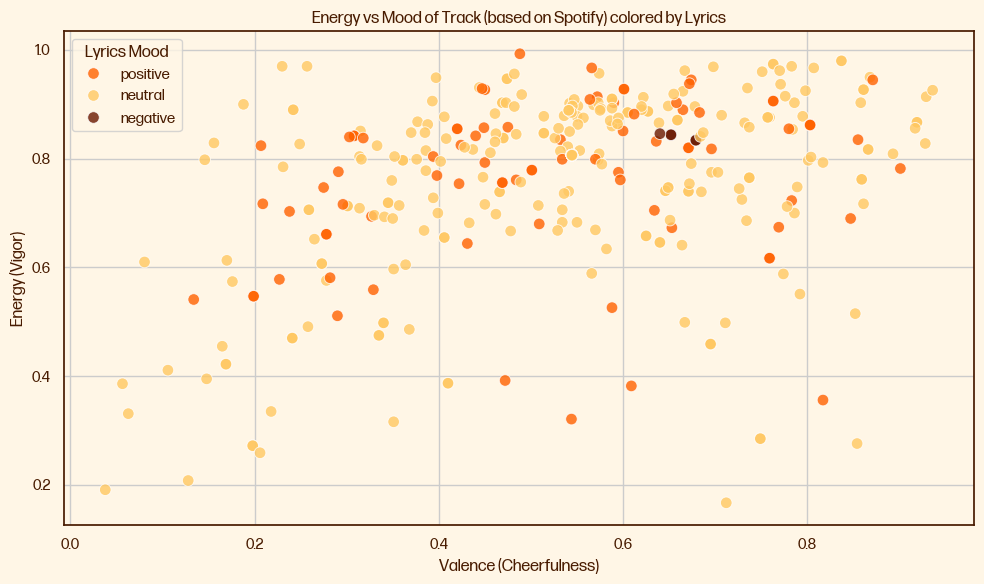

In [944]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='spotify_track_valence',
    y='spotify_track_energy',
    hue='sentiment_guess',
    palette={'positive': '#FF6200', 'neutral': '#FFC862', 'negative': '#691700'},
    alpha=0.8,
    s=70
)

plt.title('Energy vs Mood of Track (based on Spotify) colored by Lyrics')
plt.xlabel('Valence (Cheerfulness)')
plt.ylabel('Energy (Vigor)')
plt.legend(title='Lyrics Mood')
plt.grid(True)
plt.tight_layout()
plt.show()


### Такая визуализация подсказывает, насколько сильно эмоциональный посыл музыки (valence/energy) коррелирует с содержанием текстов (sentiment). Для BTS выстраивается явная связь между «светлым» музыкальным вайбом и позитивной лирикой, что подтверждает их репутацию группы, способной вдохновлять и поднимать настроение слушателям

График 2: Просчитаем исполнителя и настроение песен

/var/folders/fx/hxw23_mn2x17_m7pjjqywrbr0000gn/T/ipykernel_14108/2308088515.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


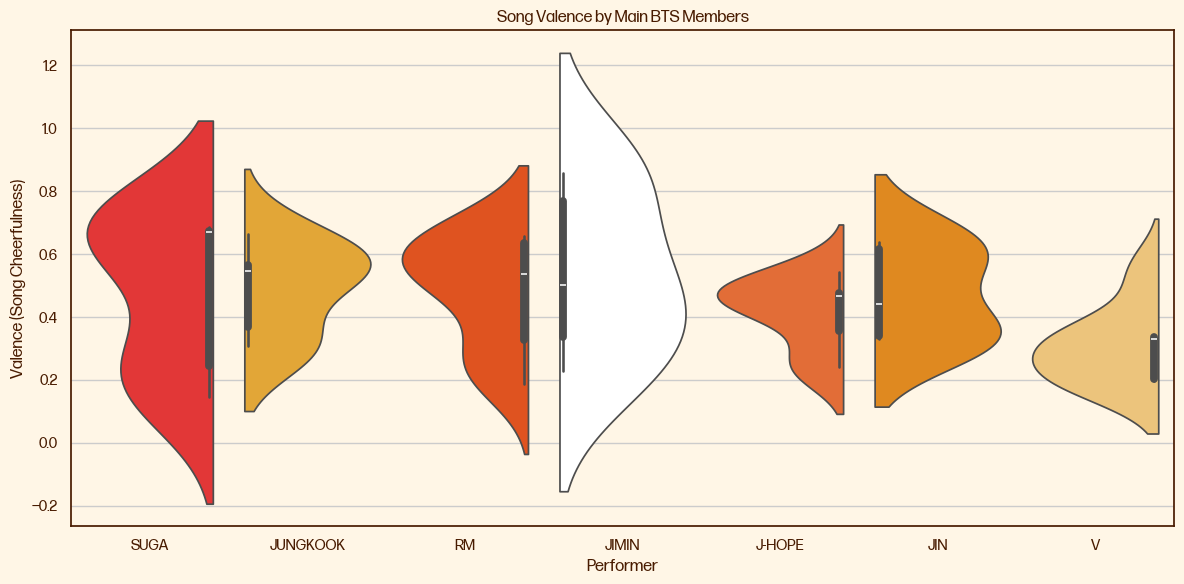

In [945]:
main_members = ['V', 'J-HOPE', 'SUGA', 'RM', 'JIMIN', 'JUNGKOOK', 'JIN']
df_main = df[df['performed_by'].isin(main_members)]
order_main = df_main.groupby('performed_by')['spotify_track_valence'].median().sort_values(ascending=False).index

custom_palette = {
    'V': '#FFCA69',
    'J-HOPE': '#FF621A',
    'SUGA': '#FF1A1A',
    'RM': '#FF4400',
    'JIMIN': '#FFFFFF',
    'JUNGKOOK': '#FFAF1A',
    'JIN': '#FF8C00'
}

plt.figure(figsize=(12, 6))
sns.violinplot(
    data=df_main,
    x='performed_by',
    y='spotify_track_valence',
    palette=custom_palette,
    order=order_main,
    split=True
)

plt.title('Song Valence by Main BTS Members')
plt.xlabel('Performer')
plt.ylabel('Valence (Song Cheerfulness)')
plt.grid(True, axis='y')
plt.tight_layout()
plt.show()

### А вывод такой — у BTS нет жёсткой привязки к одному эмоциональному «шаблону»; вместо этого они варьируют степень «весёлости» в зависимости от тематики и творческого вклада каждого участника, сохраняя при этом узнаваемое звучание и разнообразие музыкальных настроений

График 3

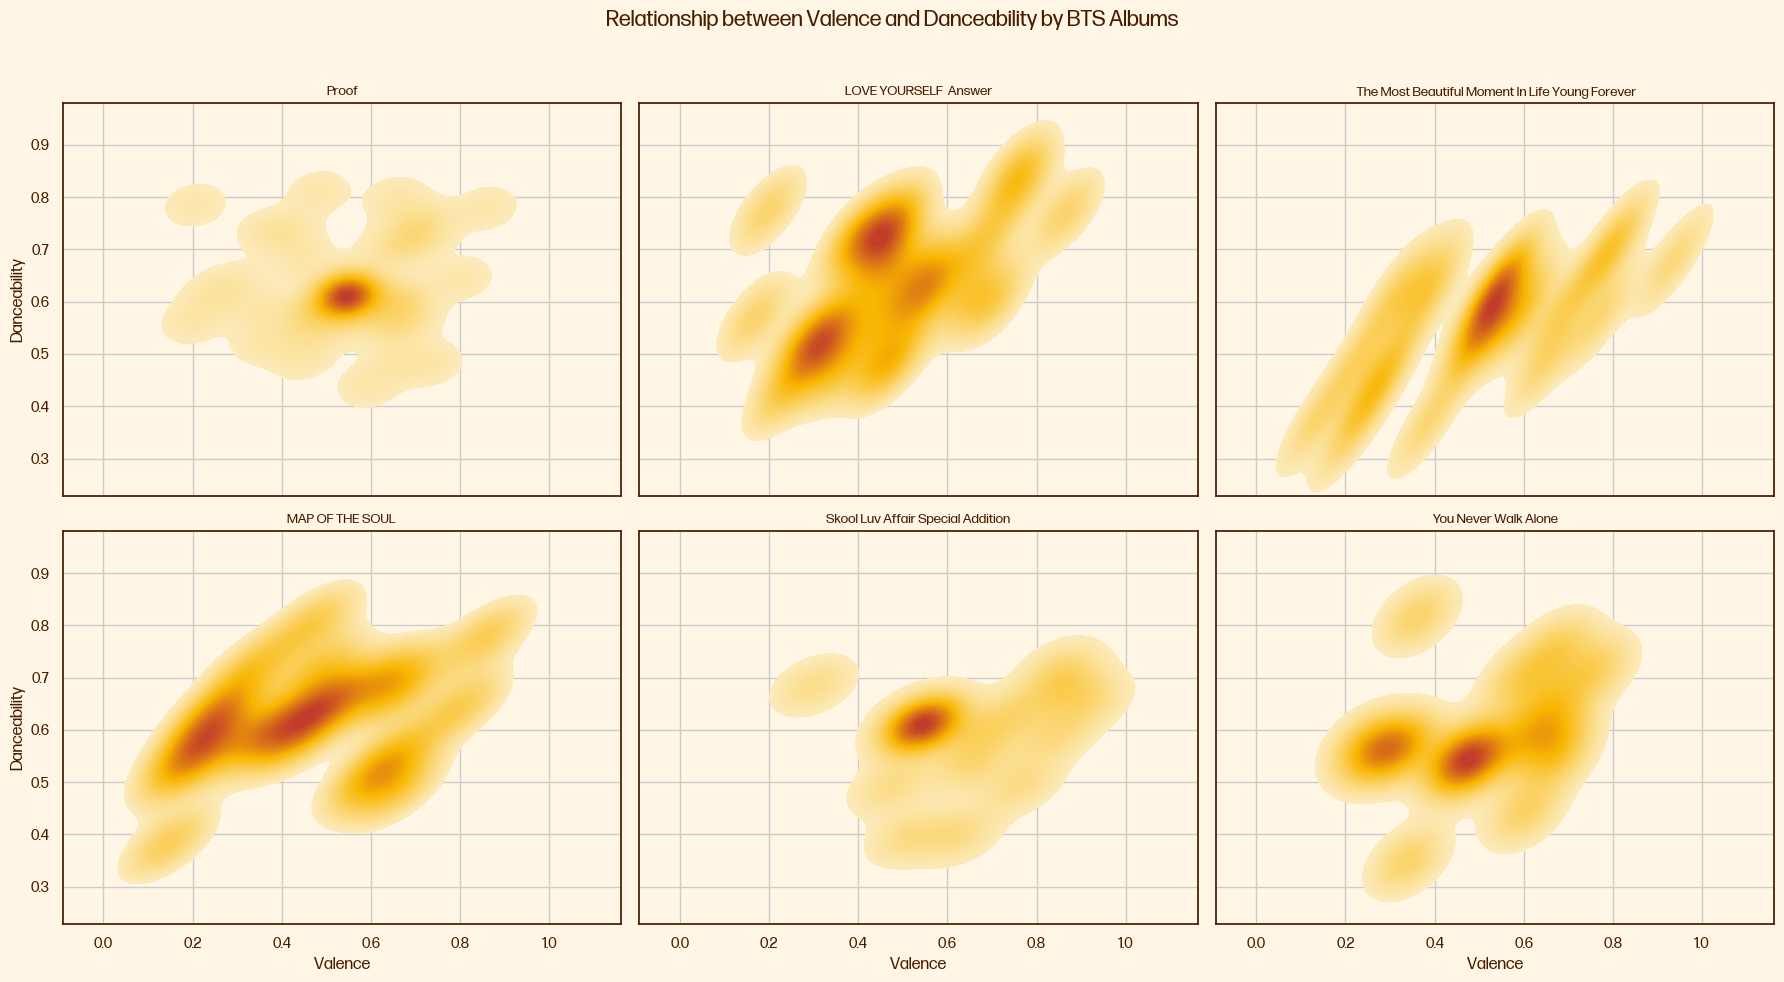

In [946]:
df['album_title'] = df['album_title'].str.replace(r'[^A-Za-z\s]', '', regex=True)
val_dance_df = df[['album_title', 'spotify_track_valence', 'spotify_track_danceability']].dropna()
top_albums = val_dance_df['album_title'].value_counts().head(6).index
filtered = val_dance_df[val_dance_df['album_title'].isin(top_albums)]
warm_cmap = LinearSegmentedColormap.from_list("warm_beige_orange", ["#fceabb", "#f8b500", "#c0392b"])
fig, axes = plt.subplots(2, 3, figsize=(18, 10), sharex=True, sharey=True)
axes = axes.flatten()

for ax, album in zip(axes, top_albums):
    album_data = filtered[filtered['album_title'] == album]
    sns.kdeplot(
        data=album_data,
        x='spotify_track_valence',
        y='spotify_track_danceability',
        fill=True,
        cmap=warm_cmap,
        bw_adjust=0.6,
        thresh=0.05,
        levels=100,
        ax=ax
    )
    ax.set_title(album, fontsize=10)
    ax.set_xlabel("Valence")
    ax.set_ylabel("Danceability")

plt.suptitle("Relationship between Valence and Danceability by BTS Albums", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Видно, что у BTS есть альбомы, где треки могут уходить в низкую эмоциональную окраску и при этом оставаться достаточно танцевальными — это говорит о сочетании энергичного ритма с более мрачным валенсом. А в других случаях (например, LOVE YOURSELF: Tear), напротив, треки нередко совмещают высокую весёлость и умеренную танцевальность, создавая «тёплую», но не всегда высокоэнергичную атмосферу

График 4: нарисуем самые частые слова

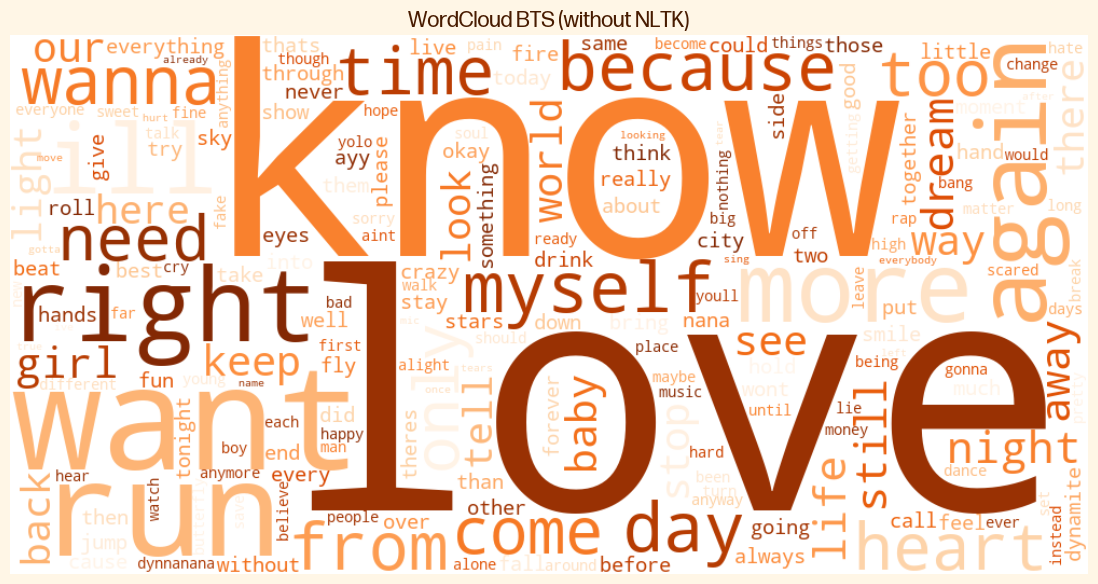

In [947]:
all_lyrics = ' '.join(df['lyrics'].dropna().astype(str)).lower()
clean_text = re.sub(r'[^a-z\s]', '', all_lyrics)
tokens = clean_text.split()
stop_words = {
    'the', 'and', 'you', 'but', 'are', 'for', 'not', 'all', 'can', 'this', 'with', 'that', 'was',
    'your', 'out', 'have', 'has', 'had', 'get', 'got', 'she', 'his', 'her', 'him', 'they', 'say',
    'sayin', 'said', 'let', 'make', 'just', 'like', 'what', 'when', 'why', 'how', 'where', 'who',
    'i', 'me', 'my', 'we', 'us', 'it', 'a', 'an', 'in', 'on', 'at', 'of', 'to', 'so', 'no', 'yes',
    'if', 'as', 'do', 'be', 'is', 'am', 'im', 'dont', 'yeah', 'uh', 'oh', 'ooh', 'la', 'na', 'u', 'its', 'youre', 'even', 'now', 'cant', 'one', 'were', 'lets', 'will', 'hey'
}

filtered_tokens = [word for word in tokens if word not in stop_words and len(word) > 2]
word_freq = Counter(filtered_tokens)
wordcloud = WordCloud(width=1000, height=500, background_color='white', colormap='Oranges')
wordcloud = wordcloud.generate_from_frequencies(word_freq)
plt.figure(figsize=(15, 7))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud BTS (without NLTK)", fontsize=16)
plt.show()

### Лирика BTS сфокусирована на прямом выражении чувств, мотивации и самопознания. Слова, отражающие «эмоциональную динамику» (love, want, run, baby), являются доминирующими и придают песням живой, исповедальный характер, который, вероятно, и вызывает столь сильный отклик у аудитории

График 5 — нарисуем эмоц. окраску каждого участника

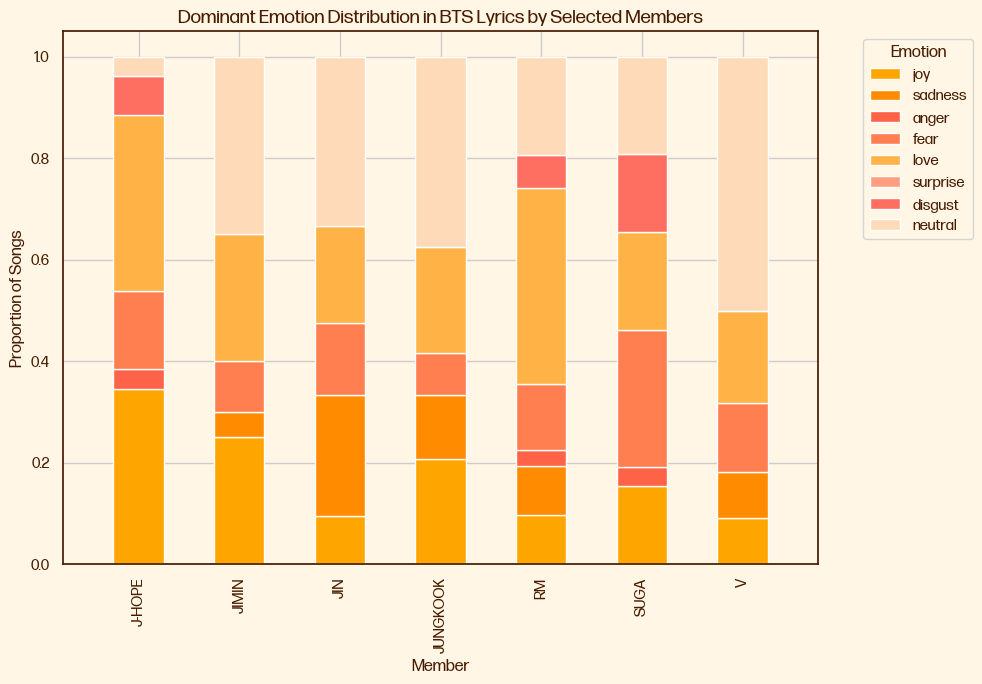

In [948]:
emotion_lexicon = {
    "joy": {"happy", "joy", "smile", "laughter", "cheerful", "delight", "fun", "excited"},
    "sadness": {"sad", "cry", "tears", "lonely", "mourn", "blue", "gloom", "heartbroken"},
    "anger": {"angry", "mad", "furious", "irate", "rage", "hate", "annoyed", "outraged"},
    "fear": {"fear", "scared", "afraid", "terrified", "panic", "dread", "anxious"},
    "love": {"love", "cherish", "affection", "passion", "romance", "adoration", "darling"},
    "surprise": {"surprised", "astonished", "amazed", "shocked", "startled"},
    "disgust": {"disgust", "repulsed", "gross", "sick", "nausea", "revulsion"}
}

def get_tokens(text):
    return re.findall(r'\w+', str(text).lower())

def classify_emotion(text):
    tokens = get_tokens(text)
    counts = {emotion: 0 for emotion in emotion_lexicon}
    for token in tokens:
        for emo, words in emotion_lexicon.items():
            if token in words:
                counts[emo] += 1
    if sum(counts.values()) == 0:
        return "neutral"
    return max(counts, key=counts.get)

df["performed_by"] = df["performed_by"].apply(lambda x: re.split(r'[;,]+', x) if isinstance(x, str) else [x])
df = df.explode("performed_by")
df["performed_by"] = df["performed_by"].str.strip()
df["dominant_emotion"] = df["lyrics"].apply(classify_emotion)
grouped = df.groupby(["performed_by", "dominant_emotion"]).size().reset_index(name="count")
pivot_df = grouped.pivot(index="performed_by", columns="dominant_emotion", values="count").fillna(0)

valid_members = ["V", "J-HOPE", "SUGA", "RM", "JIMIN", "JUNGKOOK", "JIN"]
pivot_df = pivot_df.loc[pivot_df.index.intersection(valid_members)]
pivot_pct = pivot_df.div(pivot_df.sum(axis=1), axis=0)

custom_colors = {
    "joy": "#FFA500",
    "sadness": "#FF8C00",
    "anger": "#FF6347",
    "fear": "#FF7F50",
    "love": "#FFB347",
    "surprise": "#FF9F80",
    "disgust": "#FF6F61",
    "neutral": "#FFDAB9"
}

ordered_emotions = ["joy", "sadness", "anger", "fear", "love", "surprise", "disgust", "neutral"]
pivot_pct = pivot_pct.reindex(columns=ordered_emotions, fill_value=0)

ax = pivot_pct.plot(kind="bar", stacked=True, figsize=(10, 7),
                    color=[custom_colors[emo] for emo in ordered_emotions])
plt.title("Dominant Emotion Distribution in BTS Lyrics by Selected Members", fontsize=14)
plt.xlabel("Member", fontsize=12)
plt.ylabel("Proportion of Songs", fontsize=12)
plt.legend(title="Emotion", bbox_to_anchor=(1.05, 1), loc="upper left")
num_members = len(pivot_pct.index)
plt.xlim(-0.75, num_members - 0.25)
plt.tight_layout()
plt.show()


### Большинство участников BTS явно склоняются к позитивным эмоциям (радость и любовь), но в текстах каждого из них всё же проскакивают темные нотки вроде грусти или злости. Разница в долях эмоций показывает, что у каждого свой «почерк»: кто-то чаще поет о счастье и любви, а кто-то не боится заглянуть в более мрачные чувства. В итоге такая смесь ярких и задумчивых оттенков делает общую лирику BTS более живой и близкой разным людям